### README

#### Energy Drought Analysis

**Overview**

This notebook provides a comprehensive analysis of energy droughts per country, and their association with different weather regimes. It also analyses the meteorological conditions during these energy droughts. The analysis is done for different drought intensities, ranging from medium to extreme.

#### Instructions

**Prerequisites**
- Ensure that the required Python libraries, including `numpy`, `matplotlib`, `cartopy`, and custom utilities (`utils.py` and `plot_utils.py`), are installed.

**Configuration**
1. **File Paths:** Modify the paths (`ENERGY_PATH`, `ANOM_PATH`, `PSL_PATH`) according to the location of your energy and meteorological datasets.
2. **Analysis Parameters:** Adjust the parameters related to the analysis, such as the window size, variable type, meteorological_variable to plot, and cluster ordering.
3. **Output Directories:** Update the output directories (`dir_Output`, `dir_Figures`, `dir_MeteoFigures`) to specify where the results and figures will be saved.

**Author**

Bram van Duinen

**Date (last modified)**

2024-01-19

### 1. Preliminaries

In [1]:
import utils as ut
import plot_utils as put

import os
import numpy as np
import pandas as pd
from itertools import combinations
from collections import Counter
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time

#### Options to change!

In [2]:
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_2023_PD/agg_production/per_country/'
ANOM_PATH = '/net/pc230050/nobackup/users/duinen/LENTIS/present/'
PSL_PATH = '/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d/'
WINDOW = 7
VARIABLE = 'residual' # option 2: total_RE
DTYPE = 'tas' # to show in meteo-plots, choose from tas_d, sfcWind_d, rsds_d
CLUSTER_REMAPPING = {0: int(2), 1: int(0), 2: int(1), 3: int(3), 4: int(4)} # make sure to change after new clustering run! remap the clusters to the correct order; so that names are as below, 
CLUSTER_NAMES = {0: 'NAO -', 1: 'NAO +', 2: 'Blocking', 3: 'Atl. Ridge'} 
drop_no_regime = True # set to true if  you want to drop events that occur under 'No-regime' weather regime

# SW = ['PRT', 'ESP', 'FRA', 'CHE', 'ITA']
# NW = ['NLD', 'DEU', 'BEL', 'DNK', 'GBR', 'IRL']
# N = ['NOR', 'SWE', 'FIN']
# C = ['AUT', 'CZK', 'POL', 'SVK', 'SLV']
# E = ['EST',  'HON', 'ROU', 'LVA', 'LTU', 'UKR', 'MDA']
# SE = ['BGR', 'CYP', 'GRC', 'MNE', 'SRB', 'BIH', 'HRV', 'MKD']

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{VARIABLE}/droughts_per_wr/'
dir_Figures = f'../Results/Figures/{rundate}/{VARIABLE}/droughts_per_wr/'
dir_MeteoFigures = f'../Results/Figures/{rundate}/{VARIABLE}/meteo_per_wr/'

In [3]:
ut.check_make_dir(dir_Output)
ut.check_make_dir(dir_Figures)
ut.check_make_dir(dir_MeteoFigures)

# data = ut.load_data(ENERGY_PATH, VARIABLE, stacked = False)

cluster_path = "../Results/clusters_Bayes_full_v1/clusters_full.csv"
df_wr = pd.read_csv(cluster_path)
df_wr = df_wr[['time', 'run', 'cluster_id', 'Bayes_cluster']]
df_wr['Bayes_cluster'] = df_wr['Bayes_cluster'].map(CLUSTER_REMAPPING)
df_wr['cluster_id'] = df_wr['cluster_id'].map(CLUSTER_REMAPPING)
# df_wr = df_wr.rename(columns={'Bayes_cluster': 'cluster_id'})
df_wr['time'] = pd.to_datetime(df_wr['time'])
df_wr['time'] = df_wr['time'].apply(lambda dt: dt.replace(hour=12, minute=0, second=0)) # set time to noon, to match df. Is daily average anyway

Creating dir ../Results/Data/20240311/residual/droughts_per_wr/
Creating dir ../Results/Figures/20240311/residual/droughts_per_wr/
Creating dir ../Results/Figures/20240311/residual/meteo_per_wr/


In [4]:
PATH_ED = '../../energydroughts-Europe/data/'
# ped = pd.read_csv(os.path.join(PATH_ED, 'PED_residual_q0.97_winter_LENTIS_PD_02_v4.csv')).reset_index(drop=True)
ed = pd.read_csv(os.path.join(PATH_ED, 'netto_demand_el7_winter_LENTIS_2023_PD_1600_events.csv')).reset_index(drop=True)
ed['run'] = ed['runs'].str.extract('(\d+)').astype(int)
df_events = ed.drop(['Unnamed: 0', 'runs'], axis = 1)

### 2. Define functions

In [5]:
def find_dominant_wr(df_events, df_wr, cluster_col):
    df_events['weather_regime_ids'] = None
    df_events['dominant_weather_regime'] = None

    # Iterate over the rows of overlapping_events_df
    for index, row in df_events.iterrows():
        run_condition = (df_wr['run'] == row['run'])
        date_condition = (df_wr['time'] >= row['start_time']) & (df_wr['time'] <= row['end_time'])
        
        # Filter df_wr based on run and date conditions
        relevant_weather_regimes = df_wr[run_condition & date_condition][cluster_col].tolist()
        
        dominant_2 = Counter(relevant_weather_regimes).most_common(2)
        if len(dominant_2) == 1:
            df_events.at[index, 'dominant_weather_regime'] = dominant_2[0][0]
        elif len(dominant_2) > 1:
            if dominant_2[0][1] - dominant_2[1][1] > 1: # if one regime occurs at least two days more
                df_events.at[index, 'dominant_weather_regime'] = dominant_2[0][0]
            elif dominant_2[0][1] - dominant_2[1][1] <= 1:
                df_events.at[index, 'dominant_weather_regime'] = 5 # no persisting regime #[dominant_2[0][0], dominant_2[1][0]]
        # Update the 'weather_regime_ids' column in overlapping_events_df
        df_events.at[index, 'weather_regime_ids'] = relevant_weather_regimes
    return df_events

In [6]:
def cluster_risk(df, country_list):
    """
    Calculate the risk factor (w.r.t. climatology) of energy drought events within each weather regime for a given list of countries.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        country_list (list): List of country names to filter the data.

    Returns:
        list: List of relative risks (climatology = 1) for each weather regime cluster.
    """
    df_c0 = df.query('country in @country_list and dominant_weather_regime == 0')
    df_c1 = df.query('country in @country_list and dominant_weather_regime == 1')
    df_c2 = df.query('country in @country_list and dominant_weather_regime == 2')
    df_c3 = df.query('country in @country_list and dominant_weather_regime == 3')
    df_all = df.query('country in @country_list and 0 <= dominant_weather_regime <= 3')

    r_c0 = (len(df_c0)/len(df_all) * 100) / 25
    r_c1 = (len(df_c1)/len(df_all) * 100) / 25
    r_c2 = (len(df_c2)/len(df_all) * 100) / 25
    r_c3 = (len(df_c3)/len(df_all) * 100) / 25
    risks = [r_c0, r_c1, r_c2, r_c3]
    return np.array(risks)

In [7]:
def plot_weather_regimes(df, country_name, dtype, anom_data, data_psl, lons, lats, cluster_names, dataproj = ccrs.PlateCarree(), cmap = plt.cm.RdBu_r):
    """
    Plot weather regime-specific anomalies for a given country and drought intensity, save as image file.

    Parameters:
        df (pd.DataFrame): DataFrame containing the event data.
        country_name (str): Name of the country to analyze.
        dtype (str): Type of meteorological variable ('tas', 'sfcWind', 'rsds').
        anom_data (xr.Dataset): Anomalies data.
        data_psl (xr.Dataset): Surface pressure data.
        lons (np.ndarray): Longitudes array.
        lats (np.ndarray): Latitudes array.
        cluster_names (list): List of weather regime cluster names.
        dataproj (cartopy.crs.Projection, optional): Map projection. Defaults to PlateCarree.
        cmap (matplotlib.colors.Colormap, optional): Colormap for contour plot. Defaults to RdBu_r.

    Returns:
        None
    """

    df_country = df.query(f'country == @country_name')

    vmin_vmax_dict = {
        'mild': {'tas': (-4, 4), 'sfcWind': (-4, 4), 'rsds': (-10, 10)},
        'moderate': {'tas': (-6, 6), 'sfcWind': (-5, 5), 'rsds': (-20, 20)},
        'severe': {'tas': (-8, 8), 'sfcWind': (-6, 6), 'rsds': (-25, 25)},
        'extreme': {'tas': (-10, 10), 'sfcWind': (-7, 7), 'rsds': (-30, 30)},
        'all': {'tas': (-3, 3), 'sfcWind': (-3, 3), 'rsds': (-10, 10)}
    }

    vmin, vmax = vmin_vmax_dict['extreme'][dtype] #HACK: hardcode

    plot_titles = {
        'tas': ('Temperature', '[K]'),
        'sfcWind': ('Wind speed', '[m/s]'),
        'rsds': ('Solar irradiation', '[W/m2]')
    }

    title_name, cbar_unit = plot_titles[dtype]

    fig, axs = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={'projection': dataproj})
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

    levels = np.linspace(vmin, vmax, 11)
    lon_lim, lat_lim = 40, 75
    for cluster_id in range(4):
        df_plot = df_country.query('dominant_weather_regime == @cluster_id')
        anom_plot = ut.calc_composite_mean_multipledayevent(anom_data, df_plot)
        psl_plot = ut.calc_composite_mean_multipledayevent(data_psl, df_plot)

        psl_plot = psl_plot / 100 # Pa to hPa
        ax = axs.flat[cluster_id]
        ax.set_extent([lons[0], lon_lim, lats[0], lat_lim])
        ax.set_ylim([lats[0], 75])

        norm = colors.BoundaryNorm(levels, ncolors=cmap.N, extend = 'both')
        im = ax.contourf(lons, lats, anom_plot, levels=levels, cmap=cmap, norm=norm, extend = 'both')
        CS = ax.contour(lons, lats, psl_plot, colors='k')
        ax.clabel(CS, inline=True, fontsize=10)
        put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, psl_plot, 'max', 50, 'H', color='k',
                       plotValue=False, transform=dataproj)
        put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, psl_plot, 'min', 50, 'L', color='k',
                       plotValue=False, transform=dataproj)
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        ax.set_title(f'{cluster_names[cluster_id]}, n = {len(df_plot)}')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig.colorbar(sm, cax=cbar_ax, label=cbar_unit)
    fig.suptitle(f'{title_name} anomalies per WR events in {country_name}', fontsize=16)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.savefig(f'{dir_MeteoFigures}{country_name}_{dtype}_anomalies.png', dpi = 300, bbox_inches='tight')

In [8]:
def calculate_composite_means(df, cluster_id, temp_data, wind_data, solar_data):
    df_cluster = df.query('dominant_weather_regime == @cluster_id')
    temp_mean = ut.calc_composite_mean_multipledayevent(temp_data, df_cluster)
    wind_mean = ut.calc_composite_mean_multipledayevent(wind_data, df_cluster)
    solar_mean = ut.calc_composite_mean_multipledayevent(solar_data, df_cluster)
    
    return {'tas': temp_mean, 'sfcWind': wind_mean, 'rsds': solar_mean}

def plot_allmeteo_per_wr(df_event, df_no_event, df_all, country_name, cluster_id, temp_data, wind_data, solar_data, data_psl, lons, lats, dataproj=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r):
    df_event_country = df_event.query(f'country == @country_name')
    df_all_country = df_all.query(f'country == @country_name')
    df_no_event_country = df_no_event.query(f'country == @country_name')

    vmin_vmax_dict = {
        'mild': {'tas': (-4, 4), 'sfcWind': (-4, 4), 'rsds': (-10, 10)},
        'moderate': {'tas': (-6, 6), 'sfcWind': (-5, 5), 'rsds': (-20, 20)},
        'severe': {'tas': (-8, 8), 'sfcWind': (-6, 6), 'rsds': (-25, 25)},
        'extreme': {'tas': (-10, 10), 'sfcWind': (-7, 7), 'rsds': (-30, 30)},
        'all': {'tas': (-3, 3), 'sfcWind': (-3, 3), 'rsds': (-10, 10)}
    }

    vmin, vmax = vmin_vmax_dict['extreme']  # HACK: hardcode

    plot_titles = {
        'tas': ('Temperature', '[K]'),
        'sfcWind': ('Wind speed', '[m/s]'),
        'rsds': ('Solar irradiation', '[W/m2]')
    }

    fig, axs = plt.subplots(3, 3, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1, 1.5], 'wspace': 0.3},
                            subplot_kw={'projection': dataproj})
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

    levels = np.linspace(vmin, vmax, 11)
    lon_lim, lat_lim = 40, 75

    composite_means = {
        'Event': calculate_composite_means(df_event_country, cluster_id, temp_data, wind_data, solar_data),
        'No Event': calculate_composite_means(df_no_event_country, cluster_id, temp_data, wind_data, solar_data),
        'All Days': calculate_composite_means(df_all_country, cluster_id, temp_data, wind_data, solar_data)
    }

    for row, var in enumerate(['tas', 'sfcWind', 'rsds']):
        for col, event_type in enumerate(['Event', 'No Event', 'All Days']):
            data_plot = composite_means[event_type][var]
            df_plot = {
                'Event': df_event_country,
                'No Event': df_no_event_country,
                'All Days': df_all_country
            }[event_type].query('dominant_weather_regime == @cluster_id')

            ax = axs[row, col]
            ax.set_extent([lons[0], lon_lim, lats[0], lat_lim])
            ax.set_ylim([lats[0], 75])

            norm = colors.BoundaryNorm(levels, ncolors=cmap.N, extend='both')
            im = ax.contourf(lons, lats, data_plot, levels=levels, cmap=cmap, norm=norm, extend='both')
            CS = ax.contour(lons, lats, data_psl, colors='k')
            ax.clabel(CS, inline=True, fontsize=10)
            put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, data_psl, 'max', 50, 'H', color='k',
                                   plotValue=False, transform=dataproj)
            put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, data_psl, 'min', 50, 'L', color='k',
                                   plotValue=False, transform=dataproj)
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
            gl = ax.gridlines(draw_labels=True)
            gl.top_labels = False
            gl.right_labels = False
            ax.set_title(f'{plot_titles[var][0]} - {event_type}, n = {len(df_plot)}')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig.colorbar(sm, cax=cbar_ax, label=plot_titles[var][1])
    fig.suptitle(f'Anomalies per WR events in {country_name}', fontsize=16)

    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.savefig(f'{dir_MeteoFigures}{country_name}_anomalies.png', dpi=300, bbox_inches='tight')



### 3. Find risk ratio per WR per region

In [9]:
df = find_dominant_wr(df_events, df_wr, cluster_col = 'Bayes_cluster')

In [10]:
IB = ['PRT', 'ESP']
NW = ['NLD', 'DEU', 'BEL', 'DNK', 'GBR', 'IRL']
N = ['NOR', 'SWE', 'FIN']
B =  ['EST', 'LVA', 'LTU']
C = ['AUT', 'ITA', 'CHE', 'FRA']
E = ['POL', 'HRV', 'HUN', 'SVN', 'CZE', 'SVK']

In [11]:
risks_NW = cluster_risk(df, NW) - 1
risks_IB = cluster_risk(df, IB) - 1 
risks_N = cluster_risk(df, N) - 1
risks_B = cluster_risk(df, B) - 1
risks_C = cluster_risk(df, C) - 1
risks_E = cluster_risk(df, E) - 1

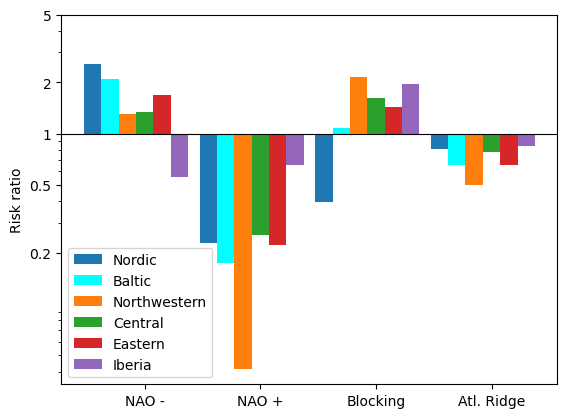

In [12]:
labels = [CLUSTER_NAMES[0], CLUSTER_NAMES[1], CLUSTER_NAMES[2], CLUSTER_NAMES[3]]

num_conditions = len(labels)

width = 0.15
positions = np.arange(num_conditions)

region_colors = {
    'Nordic': 'C0',
    'Baltic': 'cyan',
    'Northwestern': 'C1',
    'Central': 'C2',
    'Eastern': 'C3',
    'Iberia': 'C4',
}

plt.bar(positions - 3*width, risks_N, width, label='Nordic', color=region_colors['Nordic'], bottom=1)
plt.bar(positions - 2*width, risks_B, width, label='Baltic', color=region_colors['Baltic'], bottom=1)
plt.bar(positions - width, risks_NW, width, label='Northwestern', color=region_colors['Northwestern'], bottom=1)
plt.bar(positions, risks_C, width, label='Central', color=region_colors['Central'], bottom=1)
plt.bar(positions + width, risks_E, width, label='Eastern', color=region_colors['Eastern'], bottom=1)
plt.bar(positions + 2*width, risks_IB, width, label='Iberia', color=region_colors['Iberia'], bottom=1)

# Get the properties of the y-axis line
ax = plt.gca()
yaxis_line = ax.get_yaxis().get_gridlines()[0]
line_width = yaxis_line.get_linewidth()

# Draw the axhline with the same color and linewidth as the y-axis line
plt.axhline(y=1, color='k', linestyle='-', linewidth=line_width)

plt.ylabel('Risk ratio')

plt.yscale('log')
plt.yticks([0.2, 0.5, 1, 2, 5], [0.2, 0.5, 1, 2, 5])
plt.xticks(positions, labels) 
plt.legend()

## Appendix

### 6. Plot meteo conditions for droughts by country

In [13]:
temp_data, lons, lats = ut.load_anomaly(ANOM_PATH, DTYPE)
data_psl = ut.load_psl(PSL_PATH)

  0%|          | 0/160 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
temp_rolling = temp_data.rolling(time=WINDOW, center=False).mean()
psl_rolling = data_psl.rolling(time=WINDOW, center=False).mean()

### This part doesn't work

In [ ]:
country_name = 'NLD'

df_event_country = df_event.query(f'country == @country_name')
df_all_country = df_all.query(f'country == @country_name')
df_no_event_country = df_no_event.query(f'country == @country_name')

vmin_vmax_dict = {
    'mild': {'tas': (-4, 4), 'sfcWind': (-4, 4), 'rsds': (-10, 10)},
    'moderate': {'tas': (-6, 6), 'sfcWind': (-5, 5), 'rsds': (-20, 20)},
    'severe': {'tas': (-8, 8), 'sfcWind': (-6, 6), 'rsds': (-25, 25)},
    'extreme': {'tas': (-10, 10), 'sfcWind': (-7, 7), 'rsds': (-30, 30)},
    'all': {'tas': (-3, 3), 'sfcWind': (-3, 3), 'rsds': (-10, 10)}
}

vmin, vmax = vmin_vmax_dict['extreme']  # HACK: hardcode

plot_titles = {
    'tas': ('Temperature', '[K]'),
    'sfcWind': ('Wind speed', '[m/s]'),
    'rsds': ('Solar irradiation', '[W/m2]')
}

dataproj = ccrs.PlateCarree()
cmap = plt.cm.RdBu_r

fig, axs = plt.subplots(3, 3, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1, 1.5], 'wspace': 0.3},
                        subplot_kw={'projection': dataproj})
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

levels = np.linspace(vmin, vmax, 11)
lon_lim, lat_lim = 40, 75

composite_means = {
    'Event': calculate_composite_means(df_event_country, cluster_id, temp_data, wind_data, solar_data),
    'No Event': calculate_composite_means(df_no_event_country, cluster_id, temp_data, wind_data, solar_data),
    'All Days': calculate_composite_means(df_all_country, cluster_id, temp_data, wind_data, solar_data)
}

for row, var in enumerate(['tas', 'tas', 'tas']):
# for row, var in enumerate(['tas', 'sfcWind', 'rsds']):
    for col, event_type in enumerate(['Event', 'No Event', 'All Days']):
        data_plot = composite_means[event_type][var]
        df_plot = {
            'Event': df_event_country,
            'No Event': df_no_event_country,
            'All Days': df_all_country
        }[event_type].query('dominant_weather_regime == @cluster_id')

        ax = axs[row, col]
        ax.set_extent([lons[0], lon_lim, lats[0], lat_lim])
        ax.set_ylim([lats[0], 75])

        norm = colors.BoundaryNorm(levels, ncolors=cmap.N, extend='both')
        im = ax.contourf(lons, lats, data_plot, levels=levels, cmap=cmap, norm=norm, extend='both')
        CS = ax.contour(lons, lats, data_psl, colors='k')
        ax.clabel(CS, inline=True, fontsize=10)
        put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, data_psl, 'max', 50, 'H', color='k',
                                plotValue=False, transform=dataproj)
        put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, data_psl, 'min', 50, 'L', color='k',
                                plotValue=False, transform=dataproj)
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        ax.set_title(f'{plot_titles[var][0]} - {event_type}, n = {len(df_plot)}')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig.colorbar(sm, cax=cbar_ax, label=plot_titles[var][1])
fig.suptitle(f'Anomalies per WR events in {country_name}', fontsize=16)

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig(f'{dir_MeteoFigures}{country_name}_anomalies.png', dpi=300, bbox_inches='tight')

### From here, memory issues

In [ ]:
# wind_data, lons, lats = ut.load_anomaly(ANOM_PATH, 'sfcWind')
# wind_rolling = wind_data.rolling(time=WINDOW, center=False).mean()

# rsds_data, lons, lats = ut.load_anomaly(ANOM_PATH, 'rsds')
# rsds_rolling = rsds_data.rolling(time=WINDOW, center=False).mean()

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

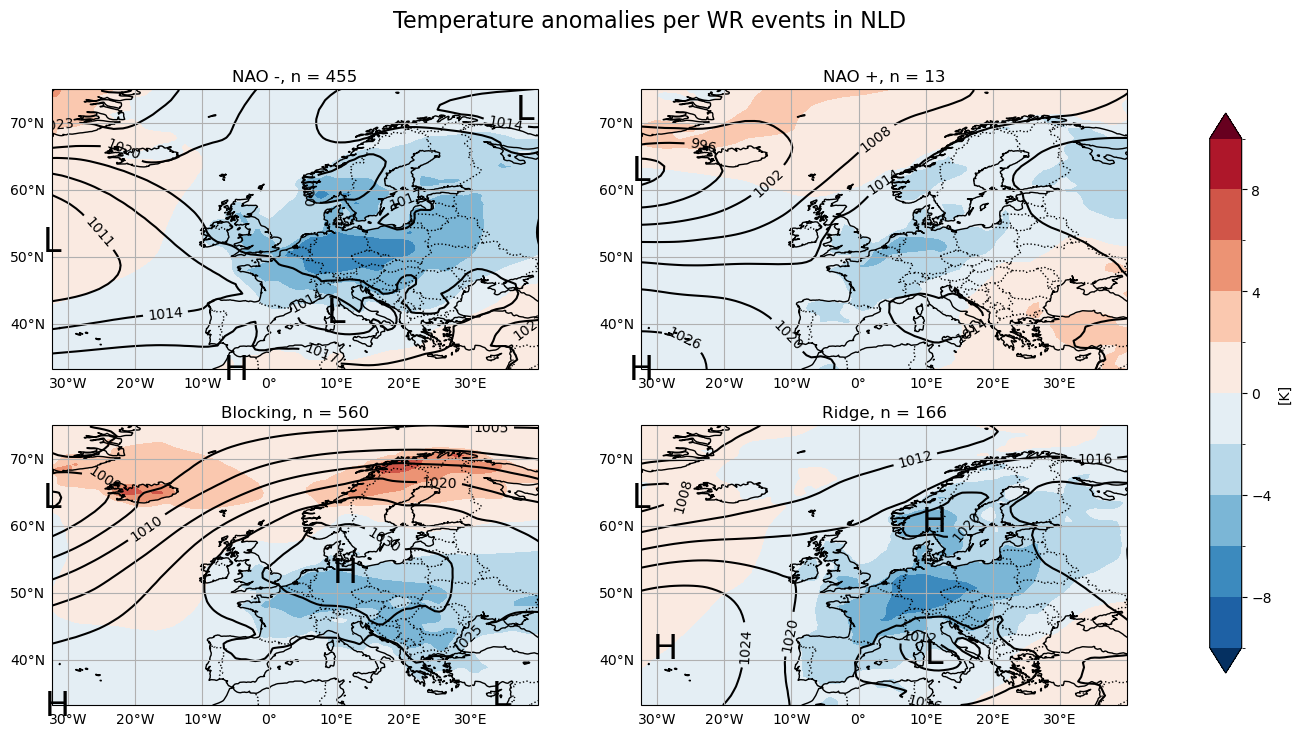

In [ ]:
plot_args = [DTYPE, anom_rolling, psl_rolling, lons, lats, CLUSTER_NAMES]
plot_weather_regimes(df_events, 'NLD', *plot_args)

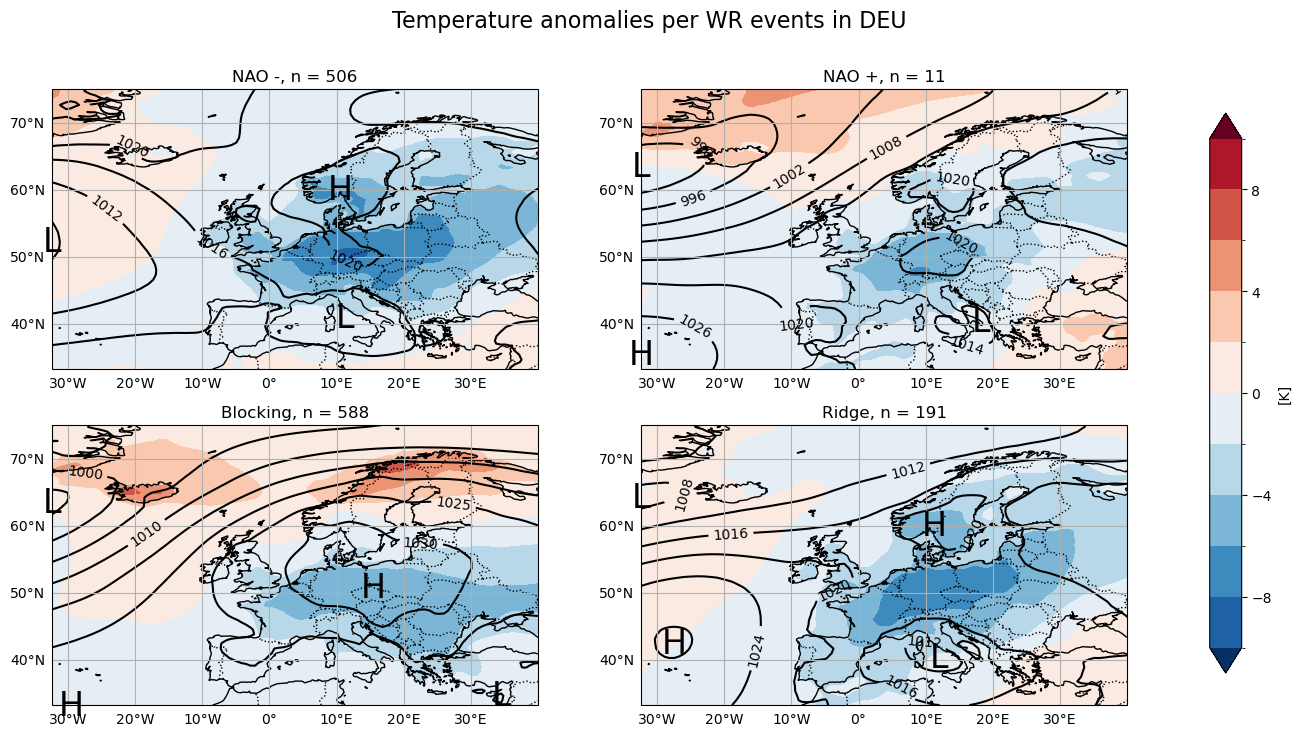

In [ ]:
plot_weather_regimes(df_events, 'DEU', *plot_args)

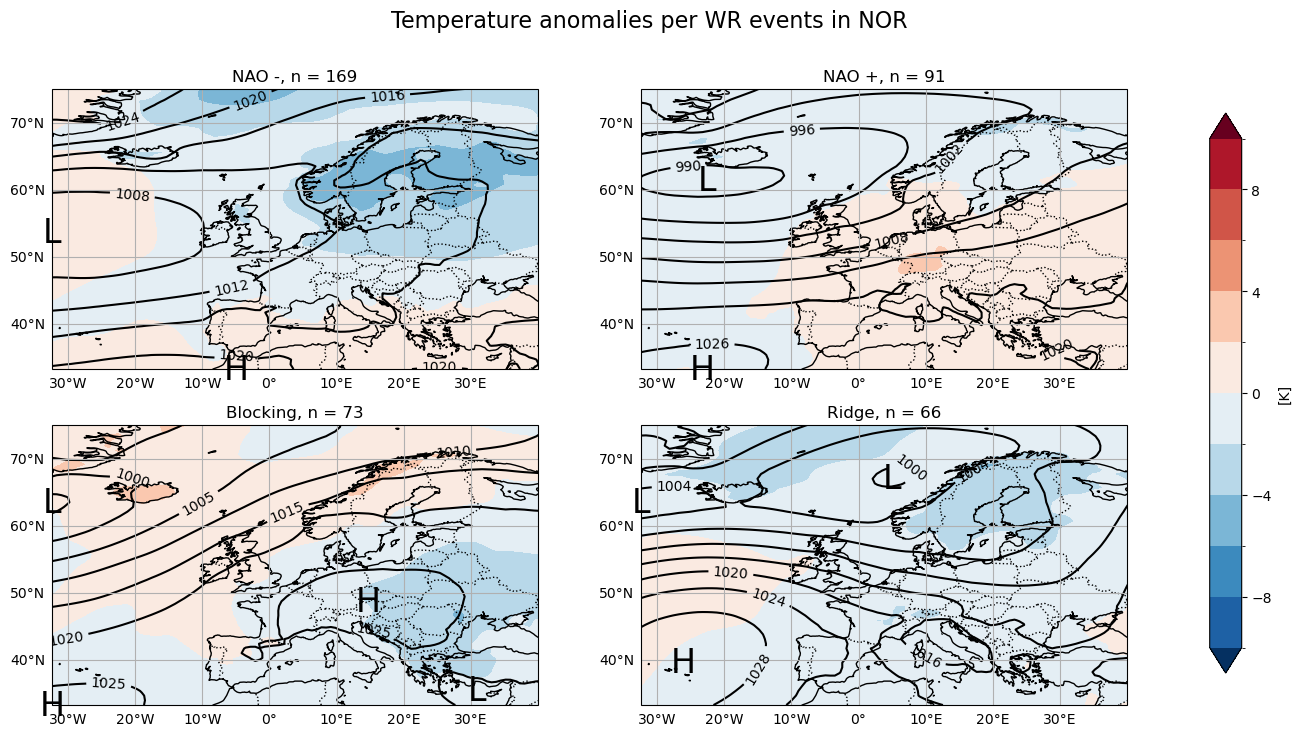

In [ ]:
plot_weather_regimes(df_events, 'NOR', *plot_args)

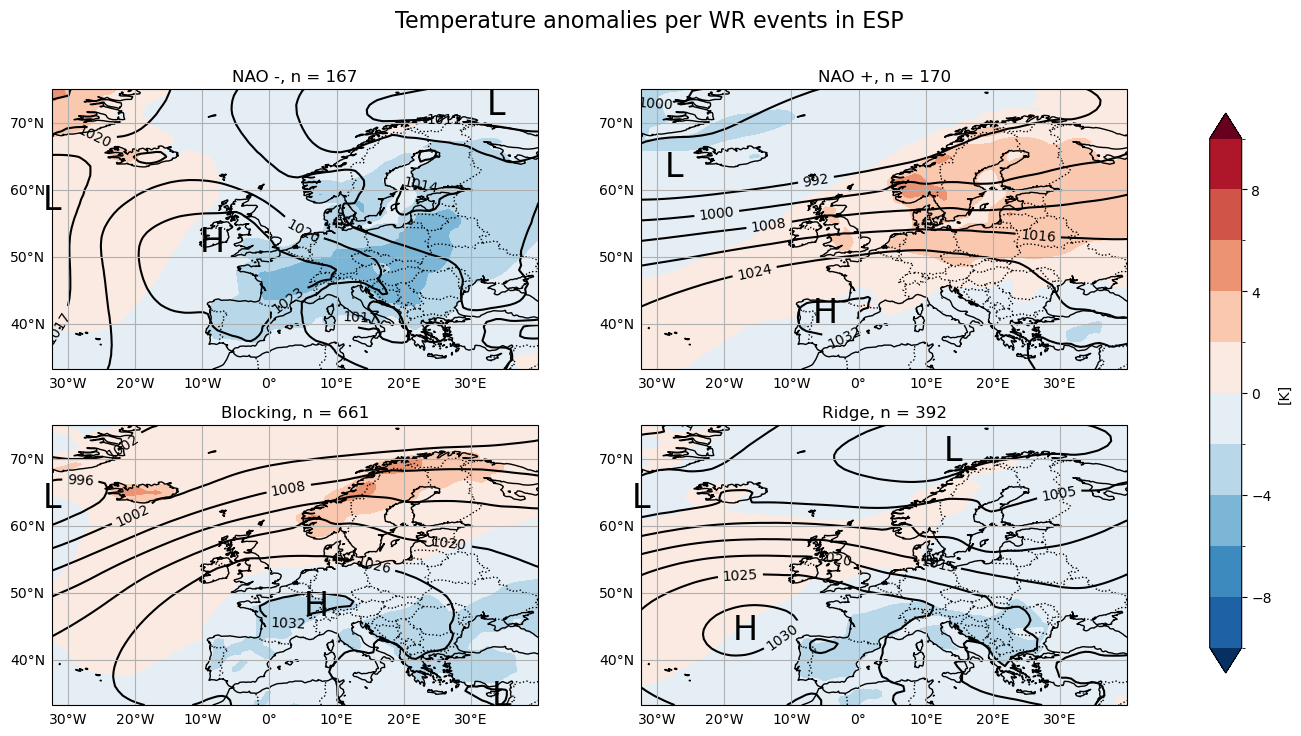

In [ ]:
plot_weather_regimes(df_events, 'ESP', *plot_args)

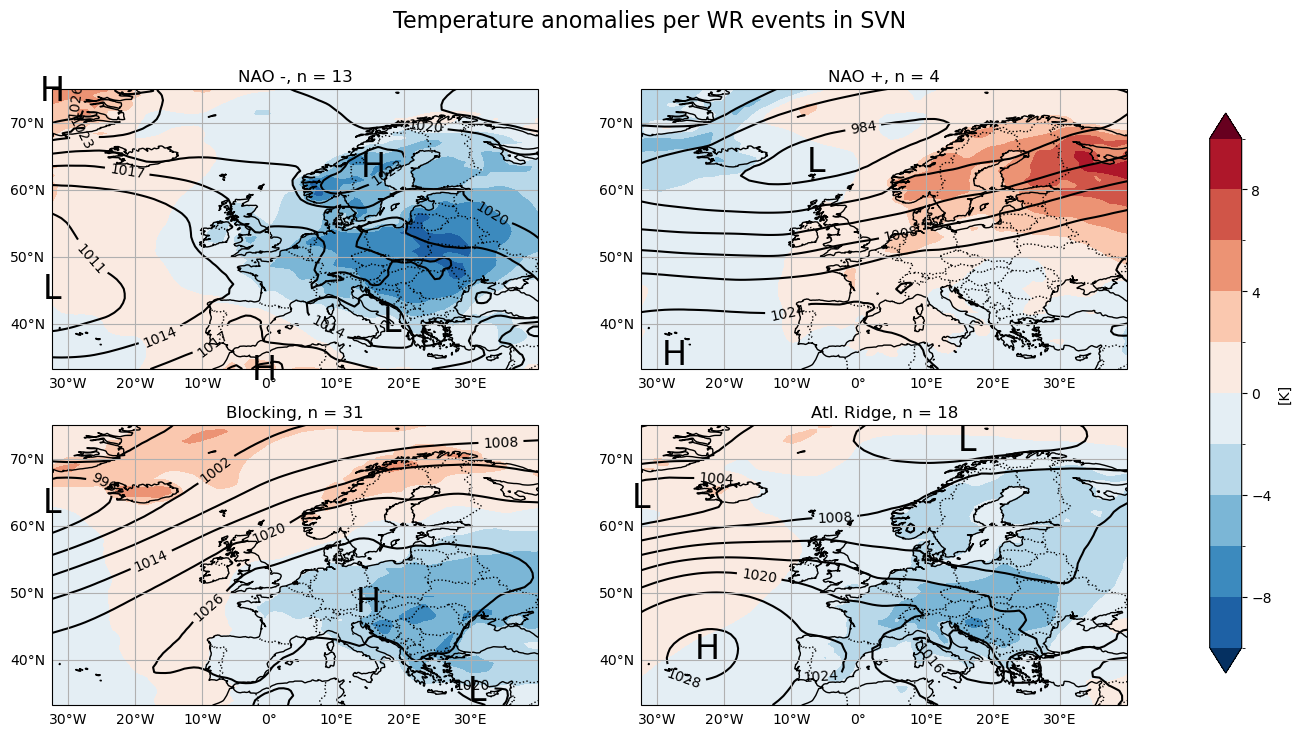

In [ ]:
plot_weather_regimes(df_events, 'SVN', *plot_args)